# Transformer models with Pytorch

[Attention is all you need](https://arxiv.org/abs/1706.03762) initially proposed the transformer architecture including new things such as attention mechanisms, optimized for text modeling.

Transformer models are the base enabling the creation of Large Language Models.

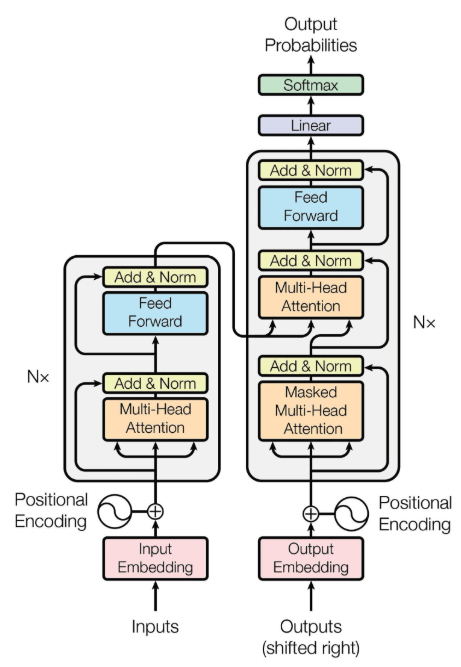

The transformer model arechitectures are composed of:
- Encoder block: composed of multiple identical blocks reading and processing the input sequence. It generates contet-rich numerical representations. It uses self-attention and feed-forward networks.
- Decoder block: does the inverse of the encoder block: generating an output sequence based on the encoded sequence.

**Positional encoding** is key to both encoder and decoder. It allows to process data simulatenously by encoding the position of each token in the sequence.

**Attention mechanisms** are focusend on the important tokens and their relationships and improves the quality of the generated text.

**Self attention** is a type of attention mechanism that asigns a weight to each token in the sequence simulaneously, capturing long range dependencies.

**Multi-head attention** is another type of attention mechanism. It extends self attention by splitting input into multiple heads to focus into different aspects of the input sequence in parallel. Heads capture distinct patterns leading to richer representations.

**Position-wise feed-forward networks** are simple NNs that apply transformations to each token independently.

In [ ]:
from torch import nn

model = nn.Transformer(
    d_model = 512,
    nhead=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
)

print(model)

- d_model: dimensionality of model inputs 
- nhead: number of attention heads
- num_encoder_layers: Numer of encoder layers
- num_decoder_layers: Numer of decoder layers


## Embedding and positional encoding

The transformer architecture starts with **embedding** sequences as vectors, and then **encoding** each token's position in the sequence so that tokens can be processed in parallel.

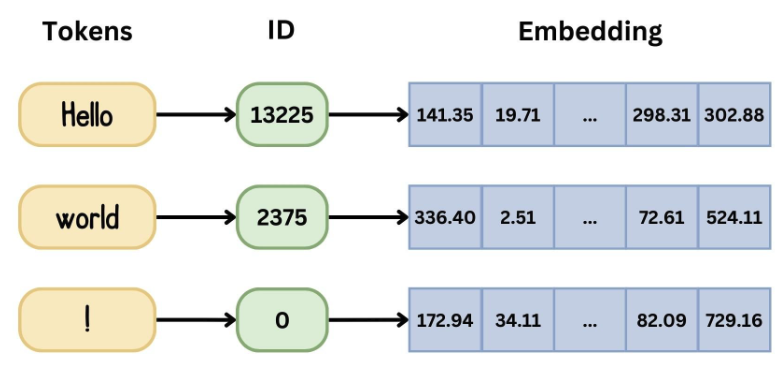

The number of dimensions of the embeddings is called dimensionlity.



In [ ]:
import torch
import math 
from torch import nn 

class InputEmbeddings(nn.Module):

    def __init__(self, vocab_size:int, d_model:int) -> None:
        super().__init__()
        self.d_model=d_model
        self.vocab_size=vocab_size
        self.embeddings=nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        # Scaling by the sqrt of the dimensionality is a standard practice that ensures the token embeddings are not overwhelmed by the positional embeddings.
        return self.embeddings(x) * math.sqrt(self.d_model)


embedding_layer = InputEmbeddings(vocab_size=10000, d_model=512)
embedded_output = embedding_layer(torch.tensor([[1,2,3,4],[5,6,7,8]]))

print(embedded_output.shape)



The dimensions match with what we expect as embeddings for a batch of 2 sequences of 4 tokens each.

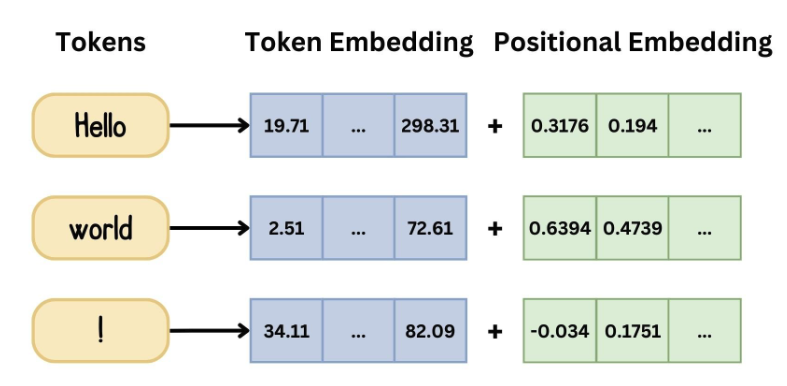

Token and positional embeddings do often have the same dimensionality so they can be easily added.

The positional embeddings are generated using the tokens position and sin (for even positions) and cosine (for odd positions) functions to generate unique positional embeddings.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) *
                             -(math.log(10000.0)/d_model))

        pe[:, 0::2]=torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # stores pe without making it a learnable parameter during training.
        self.register_buffer("pe", pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

pos_encoding_layer = PositionalEncoding(d_model=512, max_seq_length=4)
pos_encoding_output = pos_encoding_layer(embedded_output)
print(pos_encoding_output.shape)

## Multihead self-attention in transformers

Self-attention enables transformers to identify relationships between tokens and focus on the most relevant ones for the task

Given a token embedding, it is projected onto three matrices of equal dimensions representing:
- **Query**: what each token is looking for
- **Key**: content of each token
- **Values**: actual content, to be aggregated or weighted, based on the attention scores.
Transforming each token's embeddings into these roles helps the model learn more nuanced token relationships.

To obtein the matrix of attention scores between tokens, we compute the similarity between query and key using dot product metric. Applying softmax to the attention scores gives the attention weigths.

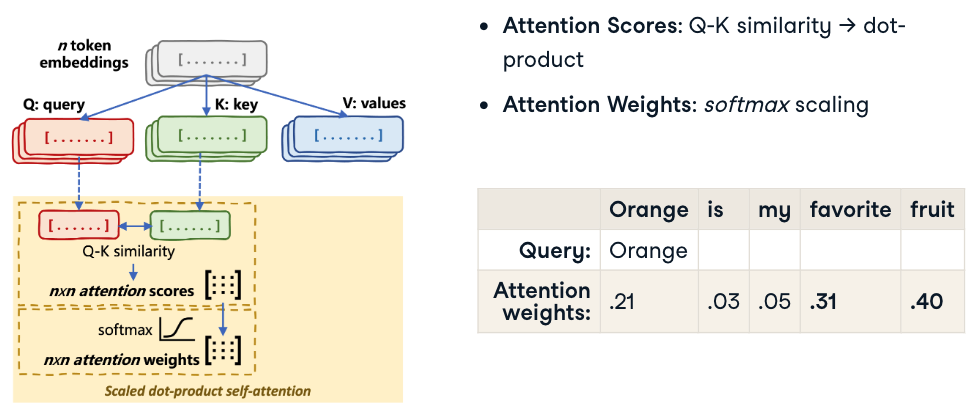

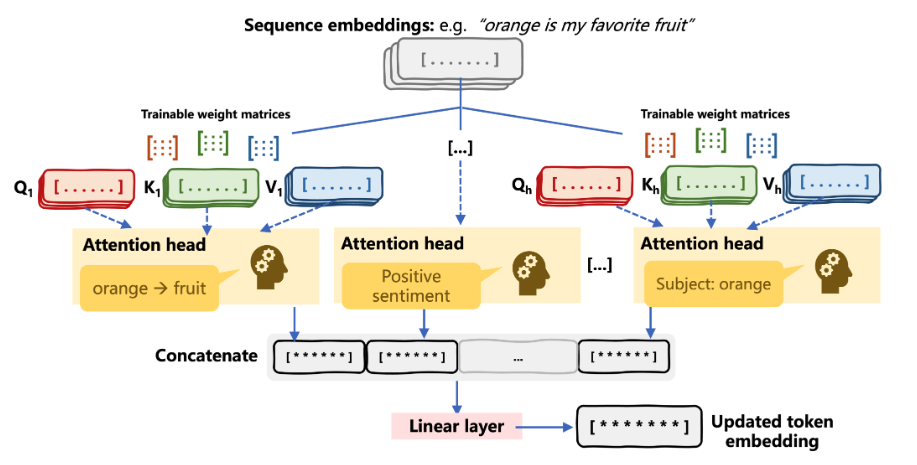


In [ ]:
from torch import nn 
import torch.nn.functional as F 

class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, num_heads):
        super().__init__()

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads

        # bias False to reduce complexity without impacting the performance
        self.query_linear = nn.Linear(d_model, d_model, bias=False)
        self.key_linear = nn.Linear(d_model, d_model, bias=False)
        self.value_linear = nn.Linear(d_model, d_model, bias=False)
        self.output_linear = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        seq_length = x.size(1)
        x = x.reshape(batch_size, seq_length, self.num_heads, self.head_dim)
        return x.permute(0,2,1,3)

    def compute_attention(self, query, key,value, mask=None):
        scores = torch.matmul(query, key.transpose(-2,-1))/(self.head_dim**0.5)
        if mask is not True:
            scores = scores.masked_fill(mask==0, float('-inf'))
        attention_weigths=F.softmax(scores, dim=-1)
        return torch.matmul(attention_weigths, value)

    def combine_heads(self, x, batch_size):
        x = x.permute(0,2,1,3).contiguous()
        return x.view(batch_size, -1, self.d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Build the forward pass
        query = self.split_heads(self.query_linear(query), batch_size)
        key = self.split_heads(self.key_linear(key), batch_size)
        value = self.split_heads(self.value_linear(value), batch_size)

        attention_weights = self.compute_attention(query, key, value, mask)
        output = self.combine_heads(attention_weights, batch_size)
        return self.output_linear(output)

